<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/36_E(3)_invariant_graph_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2094/2094), done.
remote: Compressing objects: 100% (971/971), done.
remote: Total 17115 (delta 1311), reused 1784 (delta 1121), pack-reused 15021
Receiving objects: 100% (17115/17115), 849.73 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (11503/11503), done.
Updating files: 100% (468/468), done.


In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.0 MB/s eta 0:00:00


**Contents in Theory**

Why 3D coordinates?

Representing molecules as point clouds

Equivariance and Invariance in euclidean space and why we care

**How to construct **

-invariant and equivariant models

The QM9 dataset

Contents in Practical

Visualization of point clouds

Set up and inspect the QM9 dataset

**Preprocessing**

Atomic number distribution and point cloud size

Data split, distribution of regression target electronic spatial extent

Model implementation

Plain "naive Euclidean" GNN

Demo: Plain GNNs are not E(3)-invariant

EGNN model

Demo: Our EGNN is E(3)-invariant

Training and evaluation

Setup

Training the EGNN

Training the plain GNN

Comparative evaluation

In [102]:
import math
import operator
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

In [103]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg
    !mamba install -q -y -c conda-forge pytorch_scatter


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.27.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    

In [109]:
import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

import matplotlib as mpl
import matplotlib.pyplot as plt
# from torch_scatter import scatter

In [107]:
!pip install --upgrade torch
!pip install --upgrade torch-scatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch_scatter-2.1.1.tar.gz (107 kB)
ERROR: Operation cancelled by user


In [ ]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

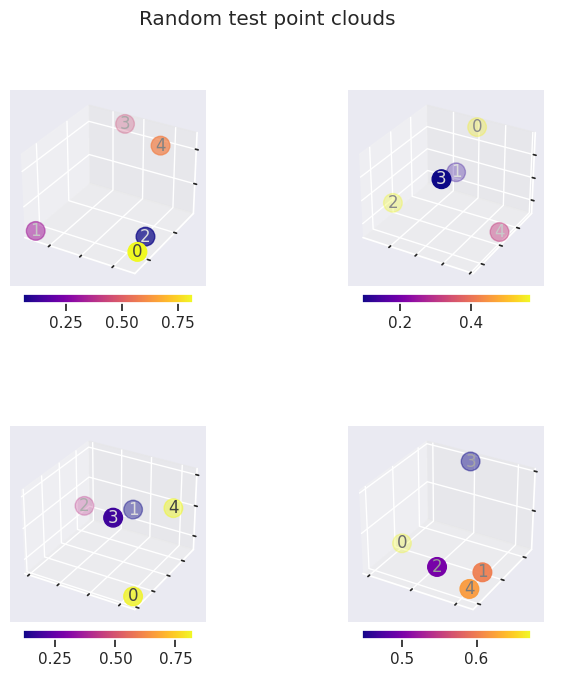

In [110]:
#Visualization of point clouds
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """
    Auxiliary function, useful for choosing label colors
    with good visibility
    """
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1


def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    color: np.ndarray,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    annotate_points: bool = True,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
) -> mpl.axis.Axis:
    """Visualize colored 3D point clouds.

    Parameters
    ----------
    fig : mpl.figure.Figure
        The figure for which a new axis object is added for plotting
    ax_pos : int
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`)
    color : np.ndarray
        The point colors as a float array of shape `(N,)`
    pos : np.ndarray
        The point xyz-coordinates as an array
    cmap : str, optional
        String identifier for a matplotlib colormap.
        Is used to map the values in `color` to rgb colors.
        , by default "plasma"
    point_size : float, optional
        The size of plotted points, by default 180.0
    label_axes : bool, optional
        whether to label x,y and z axes by default False
    annotate_points : bool, optional
        whether to label points with their index, by default True
    cbar_label : str, optional
        label for the colorbar, by default ""

    Returns
    -------
    mpl.axis.Axis
        The new axis object for the 3D point cloud plot.
    """
    cmap = mpl.cm.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    sc = ax.scatter(x, y, z, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
    if annotate_points:
        _colors = sc.cmap(color)
        rgb = _colors[:, :3].transpose()
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, zi, li) in enumerate(zip(x, y, z, brightness)):
            ax.text(xi, yi, zi, str(i), None, color=[1 - li] * 3, ha="center", va="center")
    return ax


# testing
fig = plt.figure(figsize=(8, 8))

for ax_pos in [221, 222, 223, 224]:
    pos = np.random.rand(3, 5)
    color = np.random.rand(5)
    plot_point_cloud_3d(fig, ax_pos, color, pos)

fig.suptitle("Random test point clouds")
fig.tight_layout()

In [111]:
def plot_model_input(data: Data, fig: mpl.figure.Figure, ax_pos: int) -> mpl.axis.Axis:
    """
    Plots 3D point cloud model input represented by a torch geometric
    `Data` object. Use atomic numbers as colors.

    Parameters
    ----------
    data : Data
        The 3D point cloud. Must have atomic numbers `z` and 2D coordinates `pos`
        properties that are not `None`.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    color, pos = data.z, data.pos
    color = color.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atomic number")


def plot_model_embedding(
    data: Data, model: Callable[[Data], Tensor], fig: mpl.figure.Figure, ax_pos: int
) -> mpl.axis.Axis:
    """
    Same as `plot_model_input` but instead of node features as color,
    first apply a GNN model to obtain colors from node embeddings.

    Parameters
    ----------
    data : Data
        the model input. Must have 3D coordinates `pos`
        an atomic number `z` properties that are not `None`.
    model : Callable[[Data], Tensor]
        the model must take Data objects as input and return node embeddings
        as a Tensor output.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    x = model(data)
    pos = data.pos
    color = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atom embedding (1D)")

In [112]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object.

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule
         where atomic numbers are stored in a
        tensor-valued attribute `qm9_data.z`

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    """
    Constructs a complete edge index.

    NOTE: representing complete graphs
    with sparse edge tensors is arguably a bad idea
    due to performance reasons, but for this tutorial it'll do.

    Parameters
    ----------
    n : int
        the number of nodes in the graph.

    Returns
    -------
    LongTensor
        A PyTorch `edge_index` represents a complete graph with n nodes,
        without self-loops. Shape (2, n).
    """
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    """
    On top of any edge information already there,
    add a second edge index that represents
    the complete graph corresponding to a  given
    torch geometric data object

    Parameters
    ----------
    data : Data
        The torch geometric data object.

    Returns
    -------
    Data
        The torch geometric `Data` object with a new
        attribute `complete_edge_index` as described above.
    """
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data


#
dataset = QM9(
    DATA,
    # Filter out molecules with more than 8 heavy atoms
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

print(f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}")

Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 130831


In [113]:
data = dataset[0]
# This displays all named data attributes, and their shapes (in the case of tensors), or values (in the case of other data).
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])

In [114]:
data.z

tensor([6, 1, 1, 1, 1])

In [115]:
data.pos.round(decimals=2)

tensor([[-0.0100,  1.0900,  0.0100],
        [ 0.0000, -0.0100,  0.0000],
        [ 1.0100,  1.4600,  0.0000],
        [-0.5400,  1.4500, -0.8800],
        [-0.5200,  1.4400,  0.9100]])

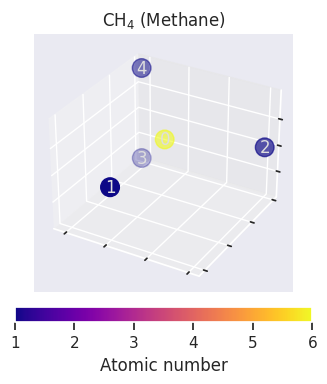

In [116]:
fig = plt.figure()
ax = plot_model_input(data, fig, 111)
_ = ax.set_title("CH$_4$ (Methane)")

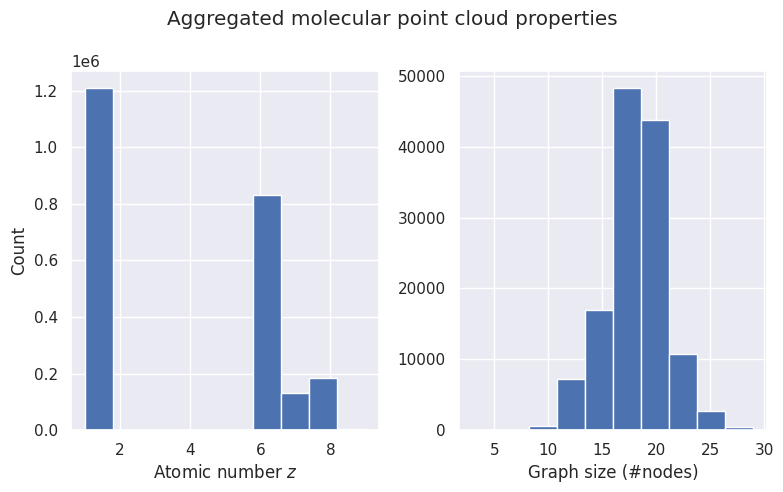

In [117]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

# ax_atoms.hist(dataset.data.z[dataset.data.z != 1])
ax_atoms.hist(dataset.data.z)
ax_atoms.set_xlabel("Atomic number $z$")
ax_atoms.set_ylabel("Count")
num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
ax_graph_size.hist(num_nodes)
ax_graph_size.set_xlabel("Graph size (#nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

In [118]:
class QM9DataModule:
    def __init__(
        self,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        target_idx: int = 5,
        seed: float = 420,
    ) -> None:
        """Encapsulates everything related to the dataset

        Parameters
        ----------
        train_ratio : float, optional
            fraction of data used for training, by default 0.8
        val_ratio : float, optional
            fraction of data used for validation, by default 0.1
        test_ratio : float, optional
            fraction of data used for testing, by default 0.1
        target_idx : int, optional
            index of the target (see torch geometric docs), by default 5 (electronic spatial extent)
            (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=qm9#torch_geometric.datasets.QM9)
        seed : float, optional
            random seed for data split, by default 420
        """
        assert sum([train_ratio, val_ratio, test_ratio]) == 1
        self.target_idx = target_idx
        self.num_examples = len(self.dataset())
        rng = np.random.default_rng(seed)
        self.shuffled_index = rng.permutation(self.num_examples)
        self.train_split = self.shuffled_index[: int(self.num_examples * train_ratio)]
        self.val_split = self.shuffled_index[
            int(self.num_examples * train_ratio) : int(
                self.num_examples * (train_ratio + val_ratio)
            )
        ]
        self.test_split = self.shuffled_index[
            int(self.num_examples * (train_ratio + val_ratio)) : self.num_examples
        ]

    def dataset(self, transform=None) -> QM9:
        dataset = QM9(
            DATA,
            pre_filter=lambda data: num_heavy_atoms(data) < 9,
            pre_transform=add_complete_graph_edge_index,
        )
        dataset.data.y = dataset.data.y[:, self.target_idx].view(-1, 1)
        return dataset

    def loader(self, split, **loader_kwargs) -> DataLoader:
        dataset = self.dataset()[split]
        return DataLoader(dataset, **loader_kwargs)

    def train_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.train_split, shuffle=True, **loader_kwargs)

    def val_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.val_split, shuffle=False, **loader_kwargs)

    def test_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.test_split, shuffle=False, **loader_kwargs)

Text(0.5, 0.98, 'Random data split - target distribution')

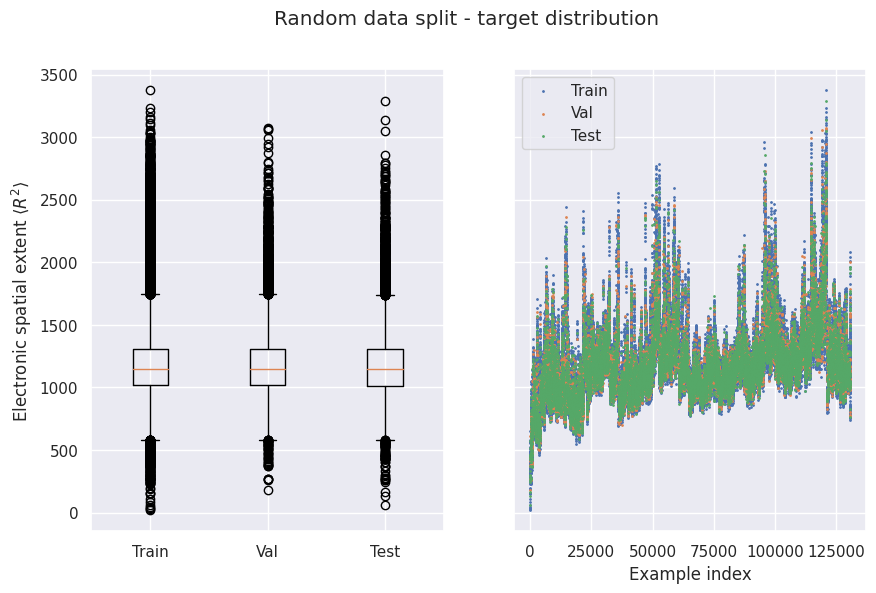

In [119]:
data_module = QM9DataModule()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
target = data_module.dataset().data.y.flatten().numpy()
ax1.boxplot(
    [
        target[data_module.train_split],
        target[data_module.val_split],
        target[data_module.test_split],
    ]
)
ax1.set_xticklabels(["Train", "Val", "Test"])
ax1.set_ylabel("Electronic spatial extent $\langle R^2 \\rangle$")

for label, split in {
    "Train": data_module.train_split,
    "Val": data_module.val_split,
    "Test": data_module.test_split,
}.items():
    ax2.scatter(split, target[split], label=label, s=1)

ax2.set_xlabel("Example index")
ax2.legend()
fig.suptitle("Random data split - target distribution")

In [120]:
class NaiveEuclideanGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        num_layers: int,
        num_spatial_dims: int,
        final_embedding_size: Optional[int] = None,
        act: nn.Module = nn.ReLU(),
    ) -> None:
        super().__init__()
        # NOTE nn.Embedding acts like a lookup table.
        # Here we use it to store each atomic number in [0,100]
        # a learnable, fixed-size vector representation
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        self.f_pos_embed = nn.Linear(num_spatial_dims, hidden_channels)
        self.f_combine = nn.Sequential(nn.Linear(2 * hidden_channels, hidden_channels), act)

        if final_embedding_size is None:
            final_embedding_size = hidden_channels

        # Graph isomorphism network as main GNN
        # (see Talktorial 034)
        # takes care of message passing and
        # Learning node-level embeddings
        self.gnn = geom_nn.models.GIN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=final_embedding_size,
            num_layers=num_layers,
            act=act,
        )

        # modules required for aggregating node embeddings
        # into graph embeddings and making graph-level predictions
        self.aggregation = geom_nn.aggr.SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            act,
            nn.Linear(final_embedding_size, 1),
        )

    def encode(self, data: Data) -> Tensor:
        # initial atomic number embedding and embedding od positional information
        atom_embedding = self.f_initial_embed(data.z)
        pos_embedding = self.f_pos_embed(data.pos)

        # treat both as plain node-level features and combine into initial node-level
        # embedddings
        initial_node_embed = self.f_combine(torch.cat((atom_embedding, pos_embedding), dim=-1))

        # message passing
        # NOTE in contrast to the EGNN implemented later, this model does use bond information
        # i.e., data.egde_index stems from the bond adjacency matrix
        node_embed = self.gnn(initial_node_embed, data.edge_index)
        return node_embed

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        aggr = self.aggregation(node_embed, data.batch)
        return self.f_predict(aggr)

Plain GNNs are not E3
-invariant

In [121]:
# use rotations along z-axis as demo e(3) transformation
def rotation_matrix_z(theta: float) -> Tensor:
    """Generates a rotation matrix and returns
    a corresponing tensor. The rotation is about the $z$-axis.
    (https://en.wikipedia.org/wiki/Rotation_matrix)

    Parameters
    ----------
    theta : float
        the angle of rotation.

    Returns
    -------
    Tensor
        the rotation matrix as float tensor.
    """
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )

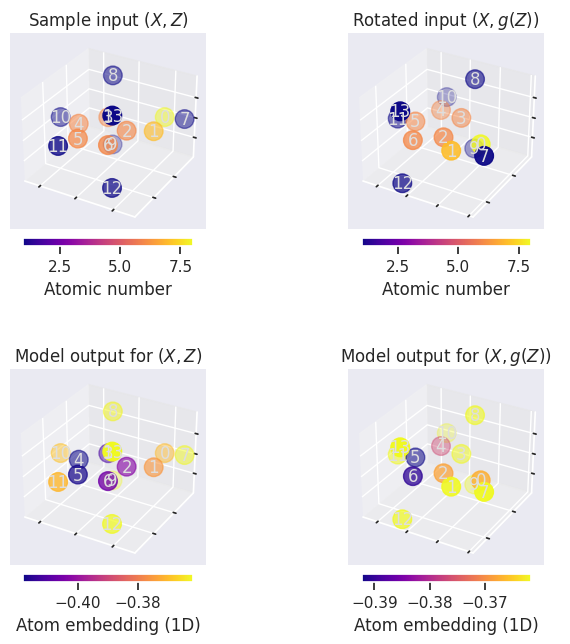

In [122]:
# Some data points from qm9
sample_data = dataset[800].clone()

# apply an E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(45)

# initialize a model with 2 hidden layers, 32 hidden channels,
# that outputs 1-dimensional node embeddings
model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    final_embedding_size=1,
)

# make a plot that demonstrates non-equivariance
# fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

# **EGNN model**

In [123]:
class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
    ) -> None:
        super().__init__()
        self.act = act
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        # Messages will consist of two (source and target) node embeddings and a scalar distance
        message_input_size = 2 * in_channels + 1

        # equation (3) "phi_l" NN
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
        )
        # equation (4) "psi_l" NN
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # h_i
        target_node_embed: Tensor,  # h_j
        node_dist: Tensor,  # d_ij
    ) -> Tensor:
        # implements equation (3)
        message_repr = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(message_repr)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        # relative squared distance
        # implements equation (2) ||X_i - X_j||^2
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)

        # compute messages "m_ij" from  equation (3)
        node_messages = self.node_message_function(node_embed[row], node_embed[col], dist)

        # message sum aggregation in equation (4)
        aggr_node_messages = scatter(node_messages, col, dim=0, reduce="sum")

        # compute new node embeddings "h_i^{l+1}"
        # (implements rest of equation (4))
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        final_embedding_size: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
    ) -> None:
        super().__init__()
        if final_embedding_size is None:
            final_embedding_size = hidden_channels

        # non-linear activation func.
        # usually configurable, here we just use Relu for simplicity
        self.act = nn.ReLU()

        # equation (1) "psi_0"
        self.f_initial_embed = nn.Embedding(100, hidden_channels)

        # create stack of message passing layers
        self.message_passing_layers = nn.ModuleList()
        channels = [hidden_channels] * (num_mp_layers) + [final_embedding_size]
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(d_in, d_out, self.act)
            self.message_passing_layers.append(layer)

        # modules required for readout of a graph-level
        # representation and graph-level property prediction
        self.aggregation = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            self.act,
            nn.Linear(final_embedding_size, target_size),
        )

    def encode(self, data: Data) -> Tensor:
        # theory, equation (1)
        node_embed = self.f_initial_embed(data.z)
        # message passing
        # theory, equation (3-4)
        for mp_layer in self.message_passing_layers:
            # NOTE here we use the complete edge index defined by the transform earlier on
            # to implement the sum over $j \neq i$ in equation (4)
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        return node_embed

    def _predict(self, node_embed, batch_index) -> Tensor:
        aggr = self.aggregation(node_embed, batch_index)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        pred = self._predict(node_embed, data.batch)
        return pred

EGNN is E(3)
-invariant

In [124]:
model = EquivariantGNN(hidden_channels=32, final_embedding_size=1, num_mp_layers=2)

AttributeError: ignored

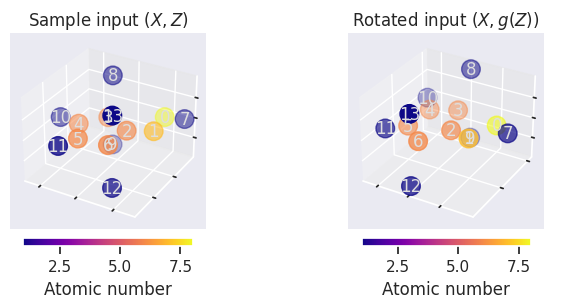

In [125]:
# Some data points from qm9
sample_data = dataset[800].clone()

# apply E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(120)

fig = plt.figure(figsize=(8, 8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

In [126]:
# We will be using mean absolute error
# as a metric for validation and testing
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    """Total absolute error, i.e. sums over batch dimension.

    Parameters
    ----------
    pred : Tensor
        batch of model predictions
    target : Tensor
        batch of ground truth / target values
    batch_dim : int, optional
        dimension that indexes batch elements, by default 0

    Returns
    -------
    Tensor
        total absolute error
    """
    return (pred - target).abs().sum(batch_dim)

In [127]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
):
    """Run a single epoch.

    Parameters
    ----------
    model : nn.Module
        the NN used for regression
    loader : DataLoader
        an iterable over data batches
    criterion : Callable[[Tensor, Tensor], Tensor]
        a criterion (loss) that is optimized
    pbar : Optional[Any], optional
        a tqdm progress bar, by default None
    optim : Optional[torch.optim.Optimizer], optional
        a optimizer that is optimizing the criterion, by default None
    """

    def step(
        data_batch: Data,
    ) -> Tuple[float, float]:
        """Perform a single train/val step on a data batch.

        Parameters
        ----------
        data_batch : Data

        Returns
        -------
        Tuple[float, float]
            Loss (mean squared error) and validation critierion (absolute error).
        """
        pred = model.forward(data_batch)
        target = data_batch.y
        loss = criterion(pred, target)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error(pred.detach(), target.detach())

    if optim is not None:
        model.train()
        # This enables pytorch autodiff s.t. we can compute gradients
        model.requires_grad_(True)
    else:
        model.eval()
        # disable autodiff: when evaluating we do not need to track gradients
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    data_module: QM9DataModule,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
    weight_decay: float = 1e-8,
    best_model_path: Path = DATA.joinpath("trained_model.pth"),
) -> Dict[str, Any]:
    """Takes data and model as input and runs training, collecting additional validation metrics
    while doing so.

    Parameters
    ----------
    data_module : QM9DataModule
        a data module as defined earlier
    model : nn.Module
        a gnn model
    num_epochs : int, optional
        number of epochs to train for, by default 30
    lr : float, optional
        "learning rate": optimizer SGD step size, by default 3e-4
    batch_size : int, optional
        number of examples used for one training step, by default 32
    weight_decay : float, optional
        L2 regularization parameter, by default 1e-8
    best_model_path : Path, optional
        path where the model weights with lowest val. error should be stored
        , by default DATA.joinpath("trained_model.pth")

    Returns
    -------
    Dict[str, Any]
        a training result, ie statistics and info about the model
    """
    # create data loaders
    train_loader = data_module.train_loader(batch_size=batch_size)
    val_loader = data_module.val_loader(batch_size=batch_size)

    # setup optimizer and loss
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-8)
    loss_fn = nn.MSELoss()

    # keep track of the epoch with the best validation mae
    # st we can save the "best" model weights
    best_val_mae = float("inf")

    # Statistics that will be plotted later on
    # and model info
    result = {
        "model": model,
        "path_to_best_model": best_model_path,
        "train_loss": np.full(num_epochs, float("nan")),
        "val_loss": np.full(num_epochs, float("nan")),
        "train_mae": np.full(num_epochs, float("nan")),
        "val_mae": np.full(num_epochs, float("nan")),
    }

    # Auxiliary functions for updating and reporting
    # Training progress statistics
    def update_statistics(i_epoch: int, **kwargs: float):
        for key, value in kwargs.items():
            result[key][i_epoch] = value

    def desc(i_epoch: int) -> str:
        return " | ".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"]
            + [
                f"{key}: {value[i_epoch]:8.2f}"
                for key, value in result.items()
                if isinstance(value, np.ndarray)
            ]
        )

    # main training loop
    for i_epoch in range(0, num_epochs):
        progress_bar = tqdm(total=len(train_loader) + len(val_loader))
        try:
            # tqdm for reporting progress
            progress_bar.set_description(desc(i_epoch))

            # training epoch
            train_loss, train_mae = run_epoch(model, train_loader, loss_fn, progress_bar, optim)
            # validation epoch
            val_loss, val_mae = run_epoch(model, val_loader, loss_fn, progress_bar)

            update_statistics(
                i_epoch,
                train_loss=train_loss,
                val_loss=val_loss,
                train_mae=train_mae,
                val_mae=val_mae,
            )

            progress_bar.set_description(desc(i_epoch))

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            progress_bar.close()

    return result

In [128]:
@torch.no_grad()
def test_model(model: nn.Module, data_module: QM9DataModule) -> Tuple[float, Tensor, Tensor]:
    """
    Test a model.

    Parameters
    ----------
    model : nn.Module
        a trained model
    data_module : QM9DataModule
        a data module as defined earlier
        from which we'll get the test data

    Returns
    -------
    _Tuple[float, Tensor, Tensor]
        Test MAE, and model predictions & targets for further processing
    """
    test_mae = 0
    preds, targets = [], []
    loader = data_module.test_loader()
    for data in loader:
        pred = model(data)
        target = data.y
        preds.append(pred)
        targets.append(target)
        test_mae += total_absolute_error(pred, target).item()

    test_mae = test_mae / len(data_module.test_split)

    return test_mae, torch.cat(preds, dim=0), torch.cat(targets, dim=0)

In [130]:
model = EquivariantGNN(hidden_channels=64, num_mp_layers=2)

egnn_train_result = train_model(
    data_module,
    model,
    num_epochs=25,
    lr=2e-4,
    batch_size=32,
    weight_decay=1e-8,
    best_model_path=DATA.joinpath("/content/teachopencadd/teachopencadd/talktorials/T036_e3_equivariant_gnn/data/trained_egnn.pth"),
)

Epoch   1 / 25 | train_loss:      nan | val_loss:      nan | train_mae:      nan | val_mae:      nan:   0%|          | 0/3680 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
gcn_baseline = NaiveEuclideanGNN(64, 4, 3)

gcn_train_result = train_model(
    data_module,
    gcn_baseline,
    num_epochs=100,
    lr=3e-4,
    batch_size=32,
    best_model_path=DATA.joinpath("/content/teachopencadd/teachopencadd/talktorials/T036_e3_equivariant_gnn/data/trained_gnn.pth"),
)

Epoch   1 / 100 | train_loss: 63277.25 | val_loss: 14573.95 | train_mae:   168.90 | val_mae:    91.05: 100%|██████████| 3680/3680 [01:26<00:00, 42.42it/s]
Epoch   2 / 100 | train_loss: 11986.86 | val_loss: 10382.88 | train_mae:    78.10 | val_mae:    76.41: 100%|██████████| 3680/3680 [01:02<00:00, 59.16it/s]
Epoch   3 / 100 | train_loss:      nan | val_loss:      nan | train_mae:      nan | val_mae:      nan:   3%|▎         | 112/3680 [00:02<00:51, 69.42it/s]

In [ ]:
gcn_num_params = sum(p.numel() for p in gcn_train_result["model"].parameters())
egnn_num_params = sum(p.numel() for p in egnn_train_result["model"].parameters())

for key, value in {"GCN": gcn_num_params, "EGNN": egnn_num_params}.items():
    print(f"{key} has {value} parameters")

In [ ]:
fig, (loss_ax, mae_ax) = plt.subplots(1, 2, figsize=(8, 4))

loss_ax.set_title("Loss (MSE)")
mae_ax.set_title("MAE")
loss_ax.set_xlabel("Epoch")
mae_ax.set_xlabel("Epoch")

for metric in ["train_loss", "val_loss", "train_mae", "val_mae"]:
    split = metric.split("_")[0]
    ax = loss_ax if "loss" in metric else mae_ax

    ax.plot(egnn_train_result[metric], label=f"EGNN {split}")
    ax.plot(gcn_train_result[metric], label=f"GNN {split}")

mae_ax.legend()
mae_ax.set_yscale("log")
loss_ax.set_yscale("log")

In [ ]:
gcn_model = gcn_train_result["model"]
gcn_model.load_state_dict(torch.load(gcn_train_result["path_to_best_model"]))
gcn_test_mae, gcn_preds, gcn_targets = test_model(gcn_model, data_module)

egnn_model = egnn_train_result["model"]
egnn_model.load_state_dict(torch.load(egnn_train_result["path_to_best_model"]))
egnn_test_mae, egnn_preds, egnn_targets = test_model(egnn_model, data_module)

print(f"EGNN test MAE: {egnn_test_mae}")
print(f"GNN test MAE: {gcn_test_mae}")

In [ ]:
fig, ax = plt.subplots()
ax.plot(gcn_targets, gcn_targets, "--", color="grey")
ax.scatter(gcn_targets, gcn_preds, s=1, label="GNN")
ax.scatter(egnn_targets, egnn_preds, s=1, label="EGNN")
ax.set_ylabel("Model prediction")
ax.set_xlabel("Ground truth $\langle R^2 \\rangle$")
ax.set_title("Test performance")
ax.legend()

You have now seen, theoretically and practically, why we need S(E)(3)
 to work with point cloud representations of molecules and how to implement, train and evaluate them. The dataset used here is not directly relevant to CADD, but the practical importance of
 equi-/invariance definitely carries over to more relevant applications such as protein ligand docking. Recent work on molecular representation learning also suggests that 3D point clouds are favored for a broad range of property prediction tasks more relevant to CADD such as toxicity prediction.